<a href="https://colab.research.google.com/github/Calaria/pytorch_models/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Counldn't find torchinfo... installling it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] Counldn't find torchinfo... installling it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 27.16 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# download data

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


# Create datasets and dataloaders

In [ ]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


Writing going_modular/data_setup.py


In [ ]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## # Create manual transform

In [ ]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),# Turn image value to between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e18d9f731c0>,
 ['pizza', 'steak', 'sushi'])

## Use auto transform from weights

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transformes to create pretrained weights
auto_trainsform = weights.transforms()
auto_trainsform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader, test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_trainsform,
                                                                               batch_size=32)
train_dataloader, test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e18d9f71270>,
 ['pizza', 'steak', 'sushi'])

# Set up pretrained model

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 84.1MB/s]


In [ ]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## show the summary of model

In [ ]:
summary(model = model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

# Froze some model parameters

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
#Set up new classifier
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True).to(device)
)

In [ ]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# Training

In [ ]:
#loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [ ]:
#Training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results=engine.train(model=model,
                     train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=5,
                                   device=device)
end_time=timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 190.236 seconds


# Evaluate model

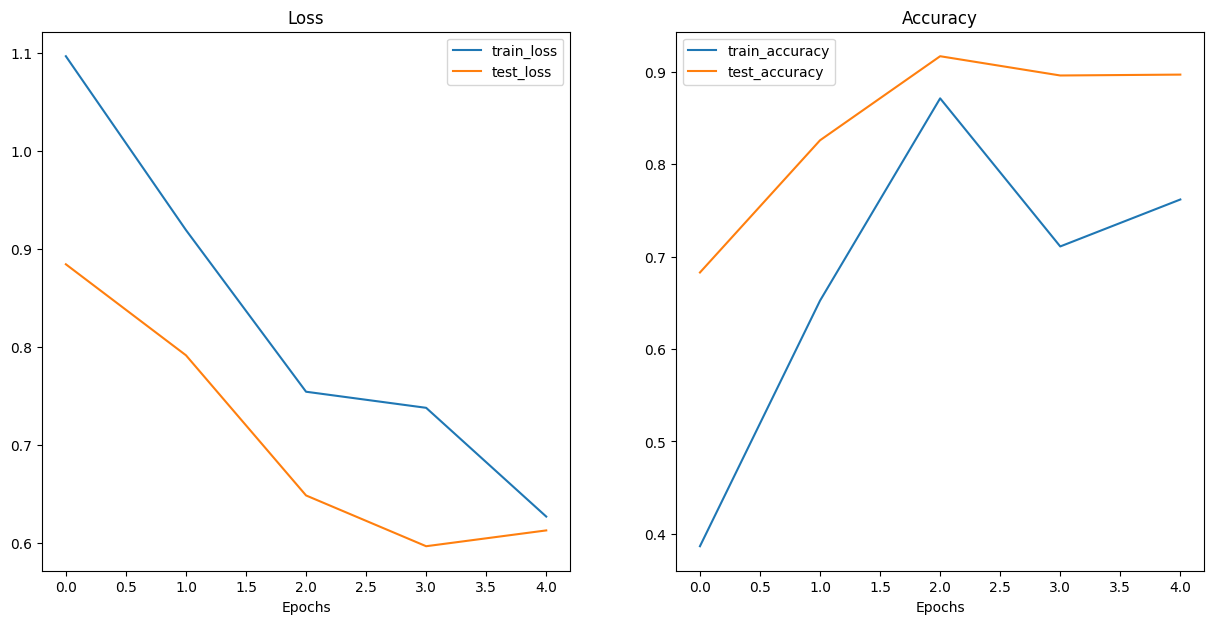

In [ ]:
# download helper function
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(results)

# Make prediction on images

In [ ]:
from modulefinder import IMPORT_NAME
from typing import List ,Tuple
from PIL import Image

def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        device:torch.device=device,
                        image_size:Tuple[int,int]= (224,224),
                        transform:torchvision.transforms = None):
  #open image
  img = Image.open(image_path)

  #transformation for image
  if transform:
    image_transform = transform
  else:
    image_transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  #go to device
  model.to(device)

  #evaluation mode
  with torch.inference_mode():
    transformed_image=image_transform(img).unsqueeze(dim=0)
    target_image_pred=model(transformed_image.to(device))

  p=torch.softmax(target_image_pred,dim=1)
  label=torch.argmax(p,dim=1)

  #Plot image with label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[label]} | Prob: {p.max():.3f}")
  plt.axis(False)




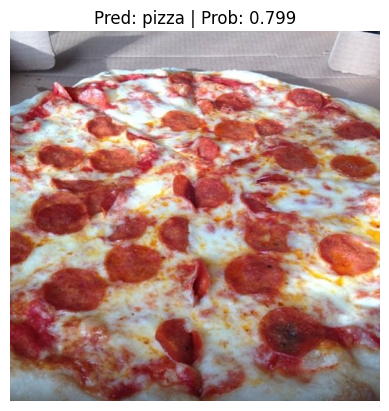

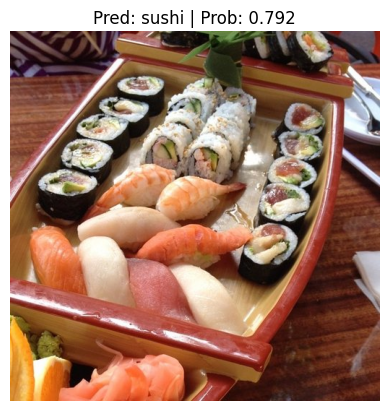

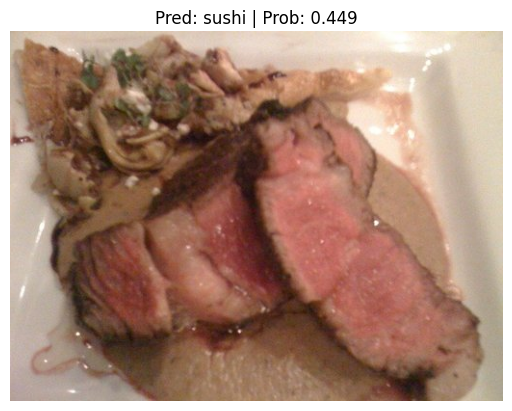

In [ ]:
# get random image paths
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample=random.sample(population=test_image_path_list,
                                     k=num_images_to_plot)
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      device=device,
                      image_size=(224,224))

# make prediction on a custom image

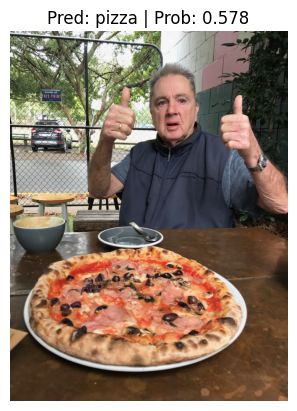

In [ ]:
# get a custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)